In [2]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import DenseVector
from pyspark.sql import functions as F

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from pyspark.sql import SparkSession

In [5]:
from handyspark import *

In [6]:
spark = SparkSession\
    .builder\
    .appName("LC_Cost_Analysis")\
    .getOrCreate()

In [7]:
#Loading predictions on the test set
best_model_predictions = pd.read_csv("data/chosen_model/predictions/label_vs_pred.csv")
bline_model_predictions = pd.read_csv("data/baseline/predictions/label_vs_pred.csv")

In [11]:
preds = pd.read_csv("data/chosen_model/predictions/data_w_predictions.csv")

In [8]:
#We will analyze the financial impact of the predictions

In [10]:
#predictions = predictions[['features', 'label', 'rawPrediction', 'probability', 'prediction']]

In [12]:
df = spark.read.option('inferschema','false').csv("data/chosen_model/predictions/data_w_predictions.csv", header=True)

In [16]:
df

DataFrame[acc_now_delinq: string, acc_open_past_24mths: string, annual_inc: string, avg_cur_bal: string, chargeoff_within_12_mths: string, collections_12_mths_ex_med: string, delinq_2yrs: string, delinq_amnt: string, dti: string, funded_amnt: string, funded_amnt_inv: string, grade: string, inq_last_6mths: string, installment: string, int_rate: string, loan_amnt: string, mo_sin_old_rev_tl_op: string, mo_sin_rcnt_rev_tl_op: string, mo_sin_rcnt_tl: string, mort_acc: string, num_accts_ever_120_pd: string, num_actv_bc_tl: string, num_actv_rev_tl: string, num_bc_sats: string, num_bc_tl: string, num_il_tl: string, num_op_rev_tl: string, num_rev_accts: string, num_rev_tl_bal_gt_0: string, num_sats: string, num_tl_30dpd: string, num_tl_90g_dpd_24m: string, num_tl_op_past_12m: string, open_acc: string, pct_tl_nvr_dlq: string, policy_code: string, pub_rec: string, pub_rec_bankruptcies: string, revol_bal: string, revol_util: string, tax_liens: string, tot_cur_bal: string, tot_hi_cred_lim: string, 

In [17]:
# Handy Spark Library 
# Creates instance of extended version of BinaryClassificationMetrics
# using a DataFrame and its probability and label columns, as the output
# from the classifier
bcm = BinaryClassificationMetrics(df, scoreCol='probability', labelCol='is_default')

In [18]:
# We can obtain the confusion matrix for any arbitrary threshold 
cm = bcm.print_confusion_matrix(.5)

In [19]:
from confusion_matrix_pretty_print import pretty_plot_confusion_matrix

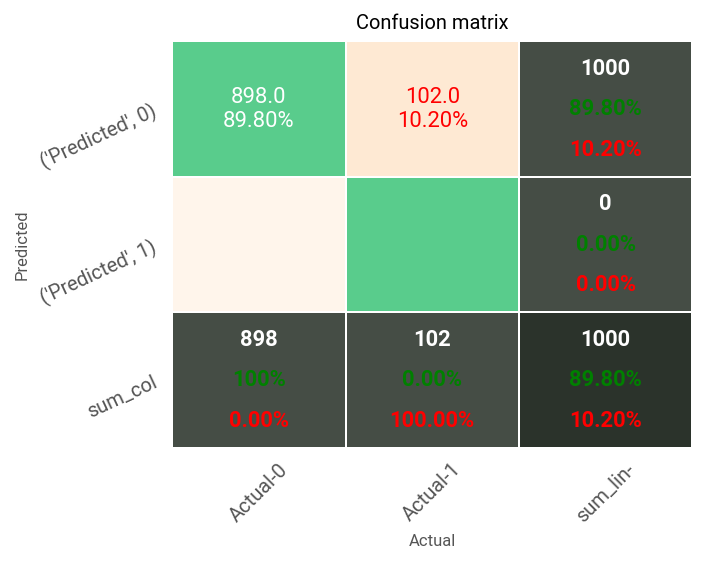

In [20]:
pretty_plot_confusion_matrix(cm, figsize=[5,4])
plt.show()

In [41]:
#We assign a cost to each of the four items in the quadrant
fp_cost = 1000
fn_cost = 10
tp_cost = 10
tn_cost = 10

In [42]:
#We assign a financial gain to true positives
tn_gain = 2000

In [43]:
def campaign_outcome(cm, fp_cost, fn_cost, tp_cost, tn_cost, tn_gain):
    
    #Quantify true/false positives and negatives 
    num_tp = cm.iloc[1,1]
    num_tn = cm.iloc[0,0]
    num_fp = cm.iloc[0,1]
    num_fn = cm.iloc[1,0]
    
    #Calculate total costs:
    campaign_cost = num_tp*tp_cost + num_tn*tn_cost + num_fp*fp_cost + num_fn*fn_cost
    campaign_gain = num_tp*tn_gain - campaign_cost
    
    print("The estimate campaign outcome is: ", campaign_gain)
    return campaign_gain
    

In [44]:
campaign_outcome(cm, fp_cost, fn_cost, tp_cost, tn_cost, tn_gain)

The estimate campaign outcome is:  -25220.0


-25220.0

In [45]:
gains = []
for thres in np.arange(0,1,0.1):
    cm = bcm.print_confusion_matrix(thres)
    campaign_gain = campaign_outcome(cm, fp_cost, fn_cost, tp_cost, tn_cost, tn_gain)
    gains.append((thres, campaign_gain))

The estimate campaign outcome is:  -25220.0
The estimate campaign outcome is:  -25220.0
The estimate campaign outcome is:  -25220.0
The estimate campaign outcome is:  -25220.0
The estimate campaign outcome is:  -25220.0
The estimate campaign outcome is:  -25220.0
The estimate campaign outcome is:  -25220.0
The estimate campaign outcome is:  -25220.0
The estimate campaign outcome is:  -25220.0
The estimate campaign outcome is:  -25220.0


In [ ]:
!pip3 install sklearn
from sklearn.metrics import confusion_matrix

In [ ]:
def create_thresholds(df):
    
    for thres in np.arange(0.1,1,0.1):
        
        col = str('pred_thres_level_'+str(thres))
        
        df[col] = [1 if i > thres else 0 for i in df['prob1']]
        
    return df      

In [ ]:
def compute_costs(tp_gain, tp_cost, tn_cost, fp_cost, fn_cost, df):
    
    campaigns = []
    
    for i in create_thresholds(df).filter(like='pred_t').columns:
        tn, fp, fn, tp = confusion_matrix(df['label'], df[i]).ravel()
        #Calculate total costs:
        campaign_cost = tp*tp_cost + tn*tn_cost + fp*fp_cost + fn*fn_cost
        campaign_gain = tp*tp_gain - campaign_cost
        campaigns.append((campaign_gain, i[17:20], tn, fp, fn, tp))
    
    campaign_df = pd.DataFrame(campaigns, columns=['NetGain', 'Threshold', 'tn', 'fp', 'fn', 'tp'])
    
    return campaign_df

In [ ]:
temp = pd.read_csv("data/chosen_model/predictions/label_vs_pred.csv")

In [ ]:
camp = compute_costs(tp_gain, tp_cost, tn_cost, fp_cost, fn_cost, temp)

In [ ]:
camp[camp.NetGain == camp.NetGain.max()]

In [ ]:
#We can redo the above but this time assign a cost to False Positive and Negatives based on Loan Value 
#A loan with a higher value will cost us more if it defaults

In [ ]:
#!pip3 install dash dash-renderer dash-html-components dash-core-components plotly
#!pip3 install flask